In [1]:
import sys
sys.path.append('..') # To find tools directory

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tools.nrcan as nrcan
import tools.bankofcanada as boc

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')

/Users/enrique/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Fetch gas prices from Natural Resource Canada
gp = nrcan.GasPriceParser()
gp_df = gp.parse()
gp_df['Price'] = gp_df['Price'] / 100 # Convert to dollars
gp_df[['Price']].describe()

,Price
count,34.000000
mean,1.114029
std,0.016063
min,1.095000
25%,1.100500
50%,1.111000
75%,1.120750
max,1.151000


In [3]:
# Fetch exchange rate from the Bank of Canada
xr = boc.ExchangeRateParser()
xr_df = xr.parse()
xr_df['FXCADUSD'] = 1 / xr_df['FXUSDCAD'] # Calculate FXCADUSD
xr_df[['FXCADUSD']].describe()

,FXCADUSD
count,33.000000
mean,0.753346
std,0.005523
min,0.735294
25%,0.752049
50%,0.753807
75%,0.755287
max,0.763650


In [21]:
# Join the two dataframes
df = gp_df.join(xr_df, how='inner')

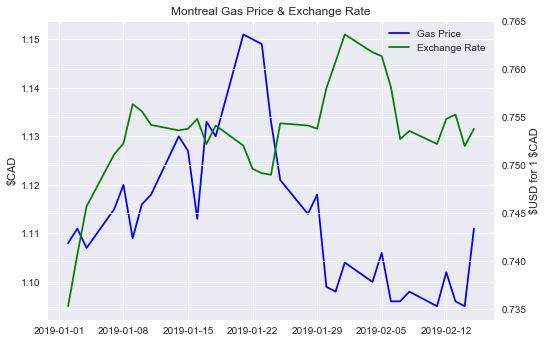

In [22]:
# Line chart to visualize the data over time
fig, ax = plt.subplots()

ax.plot(df.index.to_datetime(), df.Price, 'b', label='Gas Price')
ax.set_ylabel('\$CAD')

ax2 = ax.twinx()
ax2.plot(df.index.to_datetime(), df.FXCADUSD, 'g' , label='Exchange Rate')
ax2.set_ylabel('\$USD for 1 \$CAD')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='best')

plt.title('Montreal Gas Price & Exchange Rate')
plt.show()

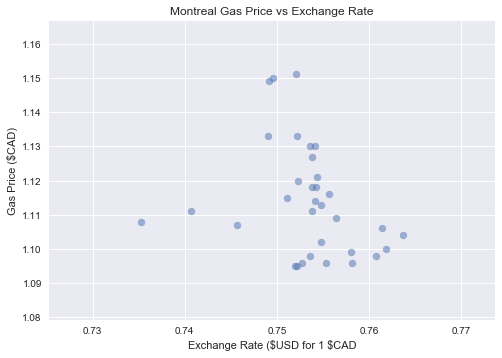

In [23]:
# Scatter plot to visualize the relationship between gas prices & exchange rates
plt.scatter(df.FXCADUSD, df.Price, alpha=0.5)
plt.title('Montreal Gas Price vs Exchange Rate')
plt.ylabel('Gas Price (\$CAD)')
plt.xlabel('Exchange Rate (\$USD for 1 \$CAD')
plt.show()

Text(0.5,0,'\\$USD for 1 \\$CAD')

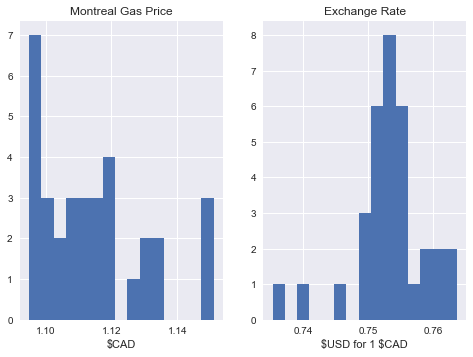

In [24]:
# Gas price & Exchange Rate histograms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(df.Price, bins=15)
ax1.set_title('Montreal Gas Price')
ax1.set_xlabel('\$CAD')
ax2.hist(df.FXCADUSD, bins=15)
ax2.set_title('Exchange Rate')
ax2.set_xlabel('\$USD for 1 \$CAD')

In [25]:
# Calculate the covariance & correlation between gas prices and exchange rates
cov = df.Price.cov(xr_df.FXCADUSD)
print('Covariance: ', cov)

corr = df.Price.corr(xr_df.FXCADUSD)
print('Correlation: ', corr)

Covariance:  -2.43131109595e-05
Correlation:  -0.270472468399


In [26]:
# Apply linear regression model to find out the intercept & slope
y = df.Price.get_values()
x = sm.add_constant(df.FXCADUSD.get_values())
model = sm.OLS(y, x)
results = model.fit()
intercept, slope = results.params
print('Intercept: ', intercept)
print('Slope: ', slope)
results.summary()

Intercept:  1.71471960761
Slope:  -0.797120894604


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.447
Date:                Sat, 16 Feb 2019   Prob (F-statistic):              0.128
Time:                        21:25:30   Log-Likelihood:                 90.831
No. Observations:                  33   AIC:                            -177.7
Df Residuals:                      31   BIC:                            -174.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7147      0.384      4.466      0.000       0.932       2.498
x1            -0.7971      0.510     -1.564      0.128      -1.836       0.242
==============================================================================
Omnibus:                        2.921   Durbin-Watson:                   0.351
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.556
Skew:                           0.664   Prob(JB):                        0.279
Kurtosis:                       2.692   Cond. No.                         288.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

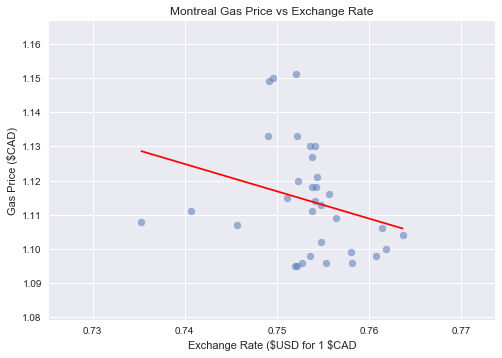

In [27]:
# Scatter plot with linear regression line
plt.scatter(df.FXCADUSD, df.Price, alpha=0.5)
plt.title('Montreal Gas Price vs Exchange Rate')
plt.ylabel('Gas Price (\$CAD)')
plt.xlabel('Exchange Rate (\$USD for 1 \$CAD')

# Calculate values for the linear regresion line
x = np.array([df.FXCADUSD.min(), df.FXCADUSD.max()])
y = slope * x + intercept
plt.plot(x, y, color='r')

plt.show()